<a href="https://colab.research.google.com/github/halisson-gomides/hacktathon-iesb-2022/blob/main/EDA_hackathonIESB_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon IESB IA - 2022

> https://www.iesb.br/noticias/hackathon-iesb-2022-maratona-com-premiacao-de-bolsas-de-pos-graduacao-comeca-dia-24-3/

> Dataset: https://github.com/mendelson/polar-sample-database


---



**Candidato:** Halisson Souza Gomides  <halisson.gomides@gmail.com>

## Config. Ambiente

In [1]:
%%capture
!pip install flatten_json
!pip install aiohttp
!pip install NBprocessing joypy cmasher
!pip install -U matplotlib

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import datetime as dt
import warnings
from flatten_json import flatten
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 500)
pd.set_option('display.expand_frame_repr', True)
warnings.simplefilter(action='ignore', category=FutureWarning)

#### biblitecas graficas

In [3]:
%reload_ext autoreload

from joypy import joyplot
import cmasher as cmr

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": 'white'})
sns.set_context('notebook', font_scale = 0.9)

## Funções úteis

In [4]:
def constructURL(user = "404",repo_name= "404",path_to_file= "404",url= "404"):
  """constói a string da URL"""
  url = url.replace("{user}",user)
  url = url.replace("{repo_name}",repo_name)
  url = url.replace("{path_to_file}",path_to_file)
  return url

In [5]:
async def fetch(session, url):
  async with session.request('GET',url=url) as response:
    if response.status != 200:
      response.raise_for_status()
    return await response.json(content_type=None)


In [6]:
async def get_content(urls):
  """Devolve o conteúdo da URL"""
  import aiohttp
  
  async with aiohttp.ClientSession() as session:
    response = await asyncio.gather(*[asyncio.ensure_future(fetch(session, url)) for url in urls])
    return response



In [7]:
def dateparse (dt_isoformat):
  """funcao que converte o dado do tipo unix timestamp no arquivo csv para o formato datetime local"""
  import pytz

  timezone = pytz.timezone('America/Sao_Paulo')
  return timezone.localize(dt.datetime.fromisoformat(dt_isoformat))

In [8]:
def grafico_quantidade(variavel, df, dict_de_para={}, paleta='jet_r', titulo='', tamanho=(10,5), orderbyqtd=True):
  
  sns.set(rc={'figure.figsize':tamanho, "axes.facecolor": 'white'})
  
  if len(dict_de_para.keys()):

    xarr = df[variavel].values
    ticks_labels  = np.array(list(dict_de_para.keys()))
    ind = np.where(xarr.reshape(xarr.size, 1) == ticks_labels)[1]

    ax = sns.countplot(y=ind, data=df, palette=paleta)
    ax.set_yticks(range(len(np.unique(ind))))
    text_labels = np.vectorize(dict_de_para.get)(ticks_labels)
    ax.set_yticklabels(text_labels[:len(np.unique(ind))])
    
  else:
    regra_ordenacao = df[variavel].value_counts().index if orderbyqtd else df[variavel].value_counts().sort_index().index
    ax = sns.countplot(y=variavel, data=df, order=regra_ordenacao, palette=paleta)
    ax.set_ylabel(None)

  ax.set_xticklabels([])
  ax.set_xlabel('quantidade')

  # valores sobre o gráfico

  for container in ax.containers:
    ax.bar_label(container, fontsize=10, fmt = '%d')

  total = df.shape[0]
  for p in ax.patches:
      percentage = '({:.1f}%)'.format(100 * p.get_width()/total)
      fator_distancia = (p.get_width()*0.05) if p.get_width()>=100 else 10
      x = p.get_x() + p.get_width() + fator_distancia
      y = p.get_y() + p.get_height() / 2 + 0.08
      ax.annotate(percentage, (x, y), size = 10)

  ax.patch.set_alpha(0.5)
  ax.set_title(titulo, fontdict={'fontsize': 14, 'fontweight':'bold'})
  return ax

In [9]:
def sub_lineplots(data, X, targets=[], colorcmr=cmr.sapphire, shape=(2,2), figsize=(16,16), sharey=True, titulo='', label_y=''):
  """cria subplots de gráficos de linha"""

  fig, axes = plt.subplots(shape[0],shape[1], figsize=figsize, sharey=sharey)
  fig.suptitle(titulo, fontsize=16, color='#404040', fontweight=600, y=0.96)
  subplots = axes.reshape(-1)
  targets = targets
  colors = cmr.take_cmap_colors(colorcmr, len(targets), cmap_range=(0.35, 0.85), return_fmt='hex')

  for i, target in enumerate(targets):
    sns.lineplot(x=X, y=data[target], color=colors[i], linewidth=3, ax=subplots[i])
    subplots[i].set_title(target)
    subplots[i].set_xlabel(None)
    subplots[i].set_ylabel(label_y)
    subplots[i].tick_params(axis='x', rotation=30)
    for ind, label in enumerate(subplots[i].get_xticklabels()):
      if ind % 10 == 0: # a cada 10, um é mantido
          label.set_visible(True)
      else:
          label.set_visible(False)

  sns.despine()
  fig.tight_layout(pad=3.0)
  return None

## Coletando os dados

In [10]:
user = 'mendelson'
repo_name = 'polar-sample-database'
path_to_file = 'dataset'
BASE_URL = 'https://api.github.com/repos/{user}/{repo_name}/contents/{path_to_file}'

json_url = constructURL(user,repo_name,path_to_file,BASE_URL)
jsonResponse = asyncio.run(get_content([json_url]))

In [11]:
df_files = pd.DataFrame.from_dict(jsonResponse[0])
df_files.head()

,name,path,sha,size,url,html_url,git_url,download_url,type,_links
0,processed_training-session-2015-06-21-11885743...,dataset/processed_training-session-2015-06-21-...,270cbf14917aa7cab43eeaab3f071ff919ae4ac4,1066265,https://api.github.com/repos/mendelson/polar-s...,https://github.com/mendelson/polar-sample-data...,https://api.github.com/repos/mendelson/polar-s...,https://raw.githubusercontent.com/mendelson/po...,file,{'self': 'https://api.github.com/repos/mendels...
1,processed_training-session-2015-06-21-11885744...,dataset/processed_training-session-2015-06-21-...,371bc2724fdec27363eacc5a216dedbdd37371ee,1293326,https://api.github.com/repos/mendelson/polar-s...,https://github.com/mendelson/polar-sample-data...,https://api.github.com/repos/mendelson/polar-s...,https://raw.githubusercontent.com/mendelson/po...,file,{'self': 'https://api.github.com/repos/mendels...
2,processed_training-session-2015-06-24-12187975...,dataset/processed_training-session-2015-06-24-...,4fb937011825b2fddc628b2ef267d9eaf84a8a12,210746,https://api.github.com/repos/mendelson/polar-s...,https://github.com/mendelson/polar-sample-data...,https://api.github.com/repos/mendelson/polar-s...,https://raw.githubusercontent.com/mendelson/po...,file,{'self': 'https://api.github.com/repos/mendels...
3,processed_training-session-2015-06-28-12487758...,dataset/processed_training-session-2015-06-28-...,90c705e115e73b4f341006f6a0eb5de2b255b883,2971217,https://api.github.com/repos/mendelson/polar-s...,https://github.com/mendelson/polar-sample-data...,https://api.github.com/repos/mendelson/polar-s...,https://raw.githubusercontent.com/mendelson/po...,file,{'self': 'https://api.github.com/repos/mendels...
4,processed_training-session-2015-07-14-14107349...,dataset/processed_training-session-2015-07-14-...,540f72a7a3997c3d90539479f73262b6ec9739e2,3146136,https://api.github.com/repos/mendelson/polar-s...,https://github.com/mendelson/polar-sample-data...,https://api.github.com/repos/mendelson/polar-s...,https://raw.githubusercontent.com/mendelson/po...,file,{'self': 'https://api.github.com/repos/mendels...


In [12]:
%%time
list_to_df = asyncio.run(get_content(list(df_files['download_url'].values)))

CPU times: user 18.8 s, sys: 5.21 s, total: 24 s
Wall time: 26.5 s


In [13]:
for i, r_file in enumerate(list_to_df):
  for e in range(len(r_file['exercises'])):
    del r_file['exercises'][e]['samples']
  list_to_df[i] = flatten(r_file)

In [14]:
dataset = pd.DataFrame(list_to_df)

In [15]:
dataset.tail()

,exportVersion,name,latitude,longitude,startTime,stopTime,timeZoneOffset,distance,kiloCalories,physicalInformationSnapshot_dateTime,physicalInformationSnapshot_sex,physicalInformationSnapshot_birthday,"physicalInformationSnapshot_height, cm","physicalInformationSnapshot_weight, kg",physicalInformationSnapshot_vo2Max,physicalInformationSnapshot_maximumHeartRate,physicalInformationSnapshot_restingHeartRate,physicalInformationSnapshot_aerobicThreshold,physicalInformationSnapshot_anaerobicThreshold,exercises_0_startTime,exercises_0_stopTime,exercises_0_timezoneOffset,exercises_0_distance,exercises_0_sport,exercises_0_latitude,exercises_0_longitude,exercises_0_kiloCalories,exercises_0_zones_heart_rate_0_lowerLimit,exercises_0_zones_heart_rate_0_higherLimit,exercises_0_zones_heart_rate_0_zoneIndex,exercises_0_zones_heart_rate_1_lowerLimit,exercises_0_zones_heart_rate_1_higherLimit,exercises_0_zones_heart_rate_1_zoneIndex,exercises_0_zones_heart_rate_2_lowerLimit,exercises_0_zones_heart_rate_2_higherLimit,exercises_0_zones_heart_rate_2_zoneIndex,exercises_0_zones_heart_rate_3_lowerLimit,exercises_0_zones_heart_rate_3_higherLimit,exercises_0_zones_heart_rate_3_zoneIndex,exercises_0_zones_heart_rate_4_lowerLimit,exercises_0_zones_heart_rate_4_higherLimit,exercises_0_zones_heart_rate_4_zoneIndex,exercises_0_zones_speed_0_lowerLimit,exercises_0_zones_speed_0_higherLimit,exercises_0_zones_speed_0_zoneIndex,exercises_0_zones_speed_1_lowerLimit,exercises_0_zones_speed_1_higherLimit,exercises_0_zones_speed_1_zoneIndex,exercises_0_zones_speed_2_lowerLimit,exercises_0_zones_speed_2_higherLimit,exercises_0_zones_speed_2_zoneIndex,exercises_0_zones_speed_3_lowerLimit,exercises_0_zones_speed_3_higherLimit,exercises_0_zones_speed_3_zoneIndex,exercises_0_zones_speed_4_lowerLimit,exercises_0_zones_speed_4_higherLimit,exercises_0_zones_speed_4_zoneIndex,feeling,exercises_0_zones_fit_fat_0_lowerLimit,exercises_0_zones_fit_fat_0_higherLimit,exercises_0_zones_fit_fat_0_inZone,exercises_0_zones_fit_fat_0_zoneIndex,exercises_0_zones_fit_fat_1_lowerLimit,exercises_0_zones_fit_fat_1_higherLimit,exercises_0_zones_fit_fat_1_inZone,exercises_0_zones_fit_fat_1_zoneIndex,note,exercises_0_zones,exercises_0_cadence_avg,exercises_0_cadence_max,physicalInformationSnapshot_functionalThresholdPower,physicalInformationSnapshot_sleepGoal,exercises_0_swimming_distance,exercises_0_swimming_freeStyle_distance,exercises_0_swimming_freeStyle_strokeCount,exercises_0_swimming_freeStyle_swimmingTimeTotal,exercises_0_swimming_freeStyle_swolfAvg,exercises_0_swimming_freeStyle_poolTime,exercises_0_swimming_backstroke_distance,exercises_0_swimming_backstroke_strokeCount,exercises_0_swimming_backstroke_swimmingTimeTotal,exercises_0_swimming_backstroke_swolfAvg,exercises_0_swimming_backstroke_poolTime,exercises_0_swimming_breaststroke_distance,exercises_0_swimming_breaststroke_strokeCount,exercises_0_swimming_breaststroke_swimmingTimeTotal,exercises_0_swimming_breaststroke_swolfAvg,exercises_0_swimming_breaststroke_poolTime,exercises_0_swimming_butterfly_distance,exercises_0_swimming_butterfly_strokeCount,exercises_0_swimming_butterfly_swimmingTimeTotal,exercises_0_swimming_butterfly_swolfAvg,exercises_0_swimming_butterfly_poolTime,exercises_0_swimming_totalStrokeCount,exercises_0_swimming_poolsSwum,exercises_0_swimming_pool_type,exercises_0_swimming_pool_length,exercises_0_swimming_freeStyle_heartRateAvg,exercises_0_swimming_freeStyle_heartRateMax,exercises_0_swimming_backstroke_heartRateAvg,exercises_0_swimming_backstroke_heartRateMax,exercises_0_swimming_breaststroke_heartRateAvg,exercises_0_swimming_breaststroke_heartRateMax,exercises_0_swimming_butterfly_heartRateAvg,exercises_0_swimming_butterfly_heartRateMax,physicalInformationSnapshot_speedCalibrationOffset
995,1.4,,-15.802092,-47.905238,2021-05-07T11:42:46.424,2021-05-07T12:21:02.782,-180.0,4022.000000,243.0,2021-05-07T15:22:13.000,MALE,1993-07-04,172.0,73.0,60.0,193.0,55.0,145.0,174.0,2021-05-07T11:42:46.457,2021-05-07T12:2

## Análise exploratória dos dados

#### Analisando os tipos

In [ ]:
dataset.dtypes

exportVersion                                            object
name                                                     object
latitude                                                float64
longitude                                               float64
startTime                                                object
stopTime                                                 object
timeZoneOffset                                          float64
distance                                                float64
kiloCalories                                            float64
physicalInformationSnapshot_dateTime                     object
physicalInformationSnapshot_sex                          object
physicalInformationSnapshot_birthday                     object
physicalInformationSnapshot_height, cm                  float64
physicalInformationSnapshot_weight, kg                  float64
physicalInformationSnapshot_vo2Max                      float64
physicalInformationSnapshot_maximumHeart

### Tranformações

In [23]:
df = dataset.copy()

In [24]:
df['startTime'] = df['startTime'].apply(dateparse)
df['stopTime'] = df['stopTime'].apply(dateparse)
df['exercises_0_startTime'] = df['exercises_0_startTime'].apply(dateparse)
df['exercises_0_stopTime'] = df['exercises_0_stopTime'].apply(dateparse)

df['ano'] = df['exercises_0_startTime'].dt.year
df['mês'] = df['exercises_0_startTime'].dt.month

### Verificação de valores ausentes

In [25]:
%reload_ext autoreload
%autoreload 2

from NBprocessing import NBgeneral
from NBprocessing import NBplot
from NBprocessing import NBcategorical

In [26]:
# verifica os valores ausentes
df_na = NBgeneral.missing_values(df)
display(df_na)

,#Missing_values,%Missing_values
physicalInformationSnapshot_speedCalibrationOffset,999,99.9
exercises_0_swimming_butterfly_heartRateMax,992,99.2
exercises_0_swimming_butterfly_heartRateAvg,992,99.2
exercises_0_zones_fit_fat_0_lowerLimit,986,98.6
exercises_0_zones_fit_fat_1_zoneIndex,986,98.6
exercises_0_zones_fit_fat_1_inZone,986,98.6
exercises_0_zones_fit_fat_1_higherLimit,986,98.6
exercises_0_zones_fit_fat_1_lowerLimit,986,98.6
exercises_0_zones_fit_fat_0_zoneIndex,986,98.6
exercises_0_zones_fit_fat_0_higherLimit,986,98.6


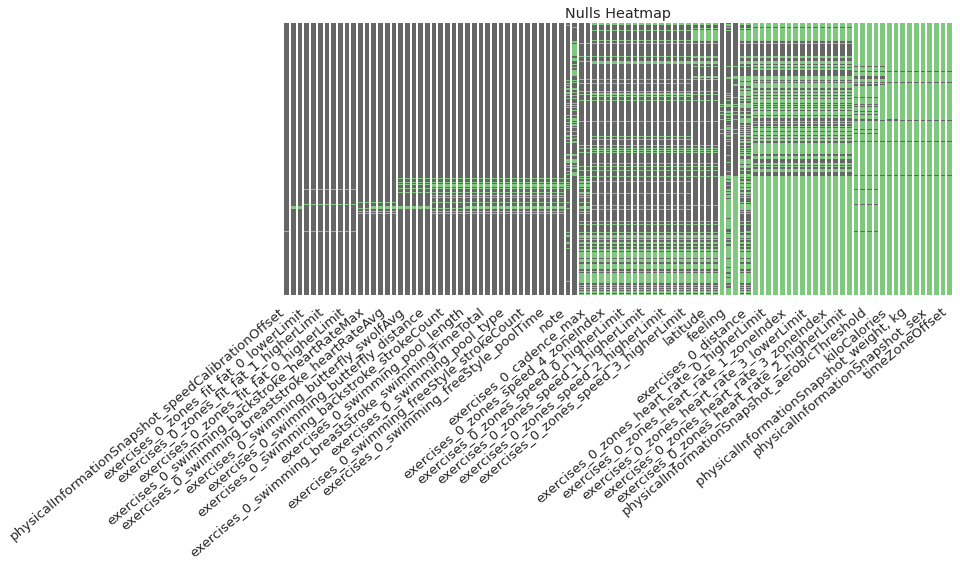

In [27]:
# Verifica o alinhamento dos valores nulos presentes nas colunas 
# para ter ideia da perda de dados em eventual descarte de valores nulos

NBplot.plot_missing_value_heatmap(df[df_na.index.to_list()])

In [28]:
# Removendo as colunas com mais de 80% de valores ausentes
data = df.drop(columns=df_na.loc[df_na['%Missing_values']>80].index.to_list()).copy()

### Análise de features

#### zonas cardíacas

In [ ]:
# avaliando dados de zonas cardíacas
data[data.columns[data.columns.str.startswith('exercises_0_zones_heart')]].describe().T

,count,mean,std,min,25%,50%,75%,max
exercises_0_zones_heart_rate_0_lowerLimit,778.0,99.068123,5.709775,97.0,97.0,98.0,99.0,124.0
exercises_0_zones_heart_rate_0_higherLimit,778.0,118.696658,7.398773,116.0,116.0,117.0,118.0,151.0
exercises_0_zones_heart_rate_0_zoneIndex,778.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
exercises_0_zones_heart_rate_1_lowerLimit,778.0,118.696658,7.398773,116.0,116.0,117.0,118.0,151.0
exercises_0_zones_heart_rate_1_higherLimit,778.0,138.713368,9.215501,135.0,136.0,137.0,138.0,179.0
exercises_0_zones_heart_rate_1_zoneIndex,778.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
exercises_0_zones_heart_rate_2_lowerLimit,778.0,138.713368,9.215501,135.0,136.0,137.0,138.0,179.0
exercises_0_zones_heart_rate_2_higherLimit,778.0,157.431877,6.646323,154.0,155.0,156.0,158.0,186.0
exercises_0_zones_heart_rate_2_zoneIndex,778.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
exercises_0_zones_heart_rate_3_lowerLimit,778.0,157.431877,6.646323,154.0,155.0,156.0,158.0,186.0


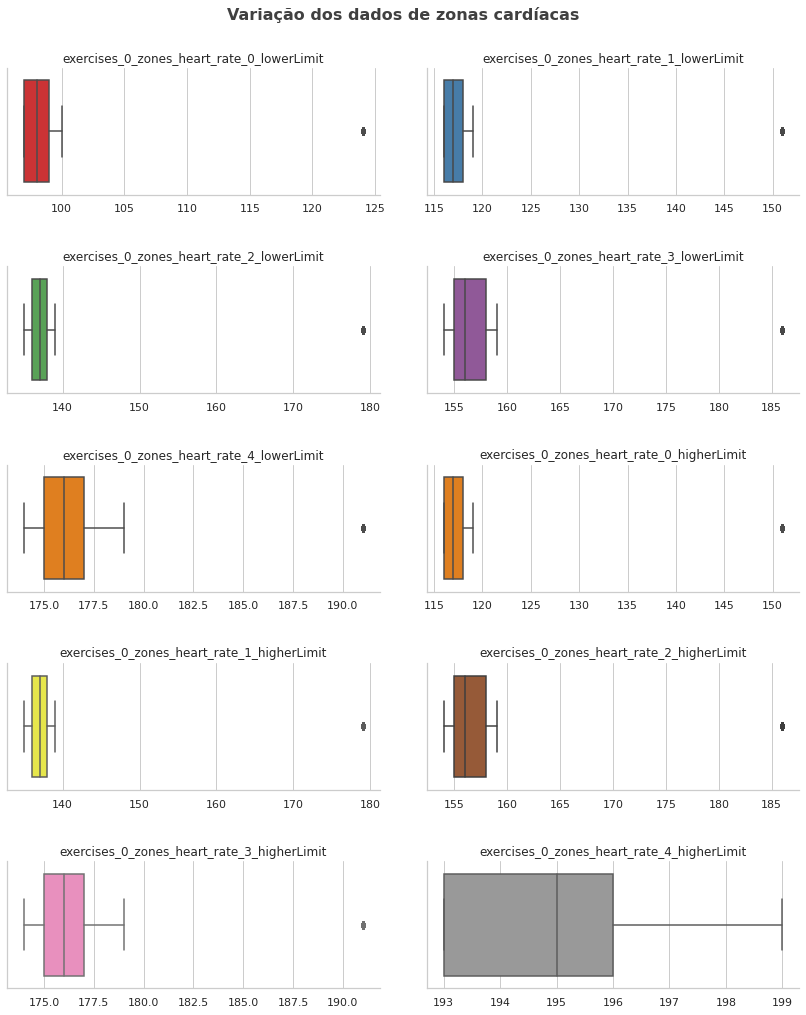

In [ ]:
# Variação dos dados de zonas cardíacas
targets = [f'exercises_0_zones_heart_rate_{i}_lowerLimit' for i in range(5)] + [f'exercises_0_zones_heart_rate_{i}_higherLimit' for i in range(5)]

fig, axes = plt.subplots(5,2, figsize=(12,15), sharey=True)
fig.suptitle('Variação dos dados de zonas cardíacas', fontsize=16, color='#404040', fontweight=600, y=0.96)
subplots = axes.reshape(-1)
colors = cmr.take_cmap_colors('Set1', 10, return_fmt='hex')
for i, target in enumerate(targets):
  sns.boxplot(data=data, x=target, color=colors[i], ax=subplots[i])
  subplots[i].set_title(target)
  subplots[i].set_xlabel(None)
  subplots[i].set_ylabel(None)

sns.despine()
fig.tight_layout(pad=3.0)
plt.show();

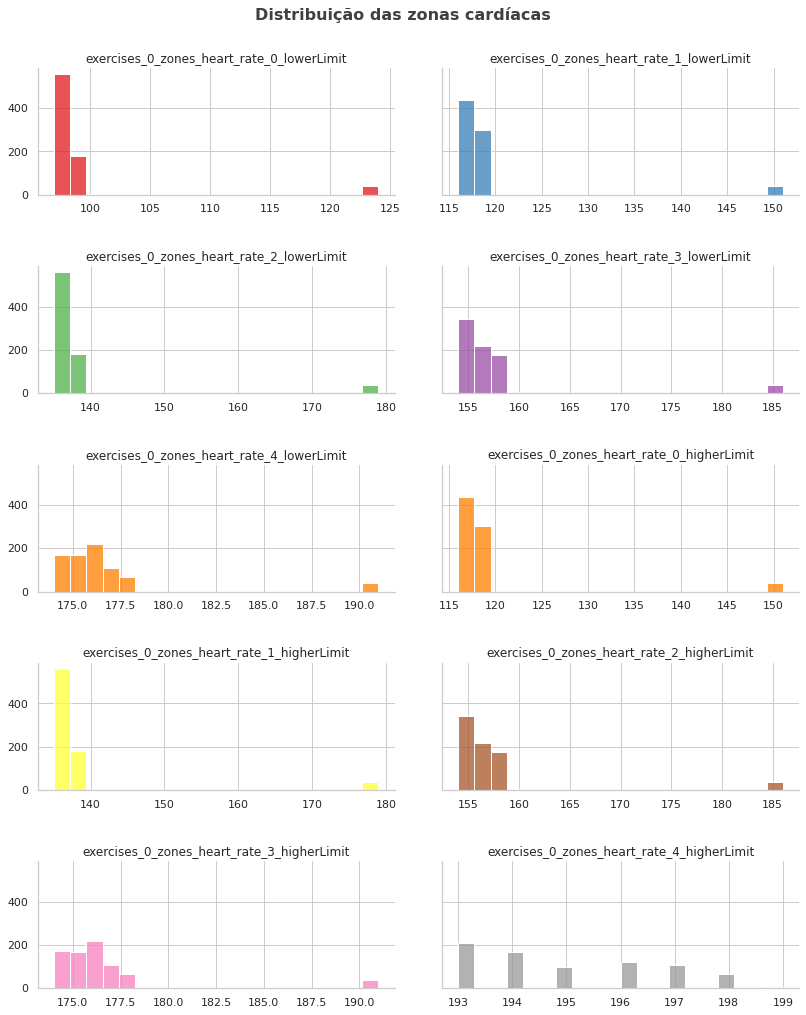

In [ ]:
# Distribuição das zonas cardíacas

fig, axes = plt.subplots(5,2, figsize=(12,15), sharey=True)
fig.suptitle('Distribuição das zonas cardíacas', fontsize=16, color='#404040', fontweight=600, y=0.96)
subplots = axes.reshape(-1)
colors = cmr.take_cmap_colors('Set1', 10, return_fmt='hex')
for i, target in enumerate(targets):
  sns.histplot(data=data, x=target, color=colors[i], bins=20, ax=subplots[i])
  subplots[i].set_title(target)
  subplots[i].set_xlabel(None)
  subplots[i].set_ylabel(None)

sns.despine()
fig.tight_layout(pad=3.0)
plt.show();

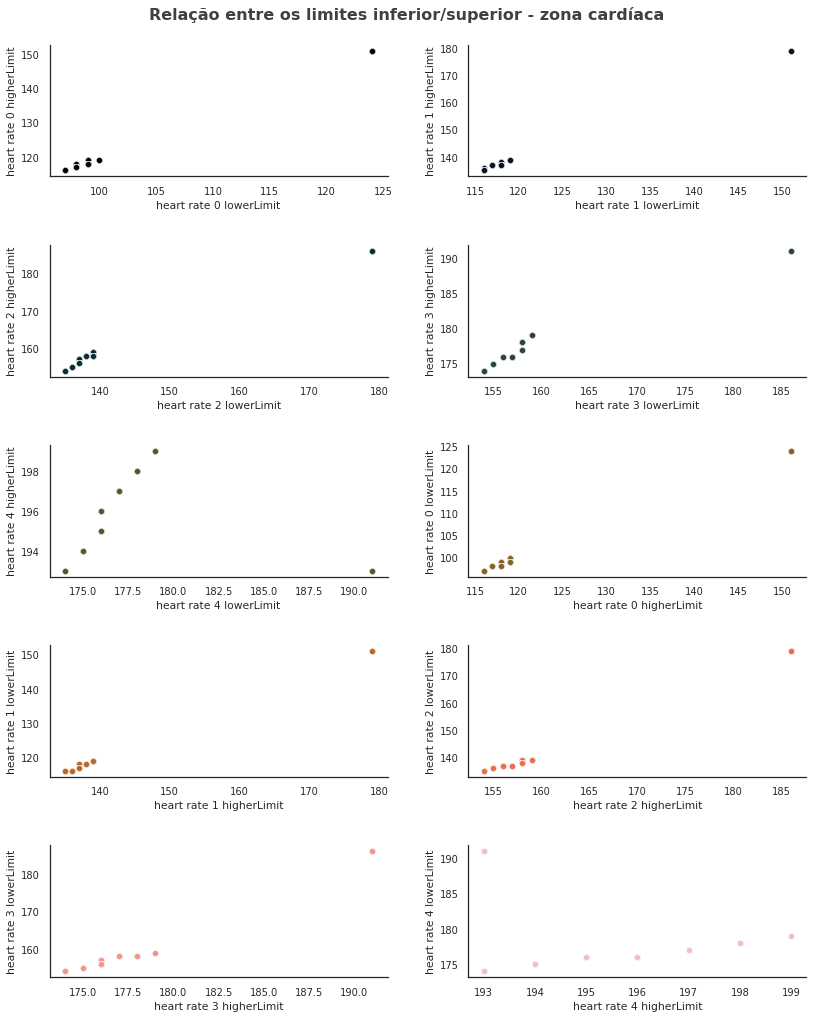

In [ ]:
# Relação entre as zonas cardíacas

targets_heart_zones = [f'exercises_0_zones_heart_rate_{i}_lowerLimit' for i in range(5)] + [f'exercises_0_zones_heart_rate_{i}_higherLimit' for i in range(5)]

fig, axes = plt.subplots(5,2, figsize=(12,15), sharey=False)
fig.suptitle('Relação entre os limites inferior/superior - zona cardíaca', fontsize=16, color='#404040', fontweight=600, y=0.96)
subplots = axes.reshape(-1)
colors = cmr.take_cmap_colors('cmr.dusk', 10, return_fmt='hex')

for i in range(len(targets_heart_zones)):
  sns.scatterplot(data[targets_heart_zones[i]], data[targets_heart_zones[-5+i]], color=colors[i], ax=subplots[i])
  subplots[i].set_xlabel(' '.join(targets_heart_zones[i].split('_')[-4:]))
  subplots[i].set_ylabel(' '.join(targets_heart_zones[-5+i].split('_')[-4:]))

sns.despine()
fig.tight_layout(pad=3.0)
plt.show();

#### zonas de velocidade

In [ ]:
# avaliando dados de zonas de velocidade
data[data.columns[data.columns.str.startswith('exercises_0_zones_speed')]].describe().T

,count,mean,std,min,25%,50%,75%,max
exercises_0_zones_speed_0_lowerLimit,290.0,6.090103,2.565700,3.0,3.00,6.70,7.89,10.0
exercises_0_zones_speed_0_higherLimit,290.0,9.195655,3.456781,7.0,7.00,7.60,9.38,20.0
exercises_0_zones_speed_0_zoneIndex,290.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.0
exercises_0_zones_speed_1_lowerLimit,290.0,9.195655,3.456781,7.0,7.00,7.60,9.38,20.0
exercises_0_zones_speed_1_higherLimit,290.0,12.095793,5.440040,8.6,10.34,10.98,11.00,30.0
exercises_0_zones_speed_1_zoneIndex,290.0,2.000000,0.000000,2.0,2.00,2.00,2.00,2.0
exercises_0_zones_speed_2_lowerLimit,290.0,12.095793,5.440040,8.6,10.34,10.98,11.00,30.0
exercises_0_zones_speed_2_higherLimit,290.0,15.047724,7.760273,9.3,11.54,12.20,15.00,40.0
exercises_0_zones_speed_2_zoneIndex,290.0,3.000000,0.000000,3.0,3.00,3.00,3.00,3.0
exercises_0_zones_speed_3_lowerLimit,290.0,15.047724,7.760273,9.3,11.54,12.20,15.00,40.0


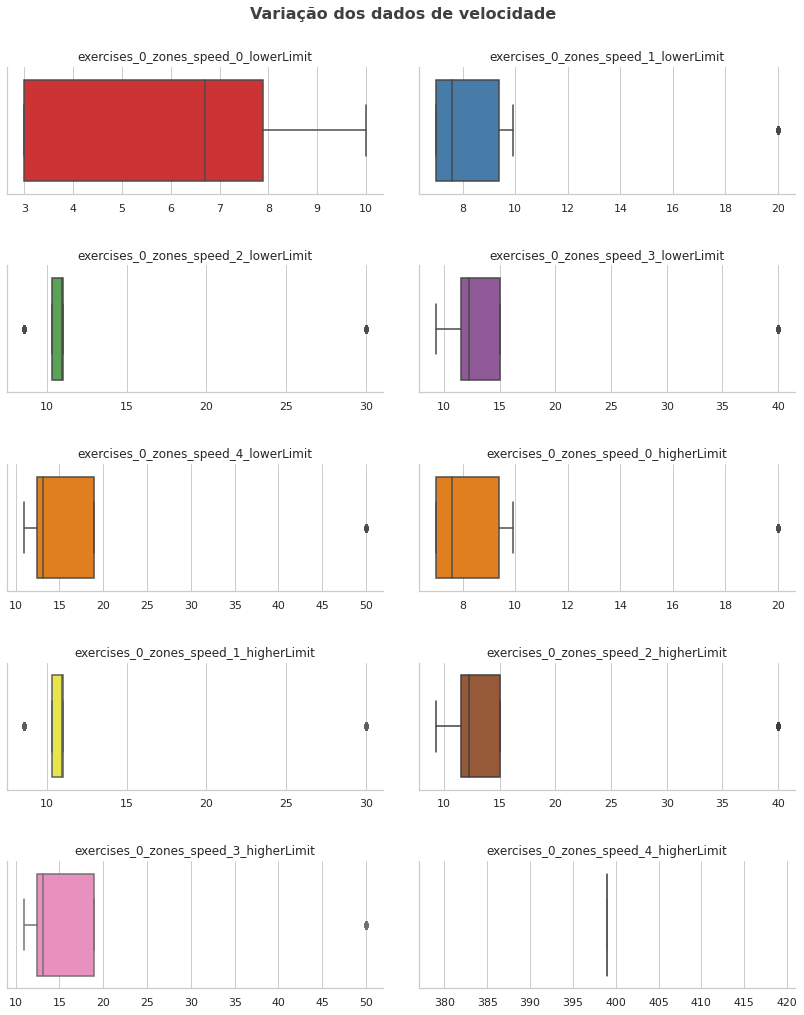

In [ ]:
targets = [f'exercises_0_zones_speed_{i}_lowerLimit' for i in range(5)] + [f'exercises_0_zones_speed_{i}_higherLimit' for i in range(5)]

fig, axes = plt.subplots(5,2, figsize=(12,15), sharey=True)
fig.suptitle('Variação dos dados de velocidade', fontsize=16, color='#404040', fontweight=600, y=0.96)
subplots = axes.reshape(-1)
colors = cmr.take_cmap_colors('Set1', 10, return_fmt='hex')
for i, target in enumerate(targets):
  sns.boxplot(data=data, x=target, color=colors[i],ax=subplots[i])
  subplots[i].set_title(target)
  subplots[i].set_xlabel(None)
  subplots[i].set_ylabel(None)

sns.despine()
fig.tight_layout(pad=3.0)
plt.show();

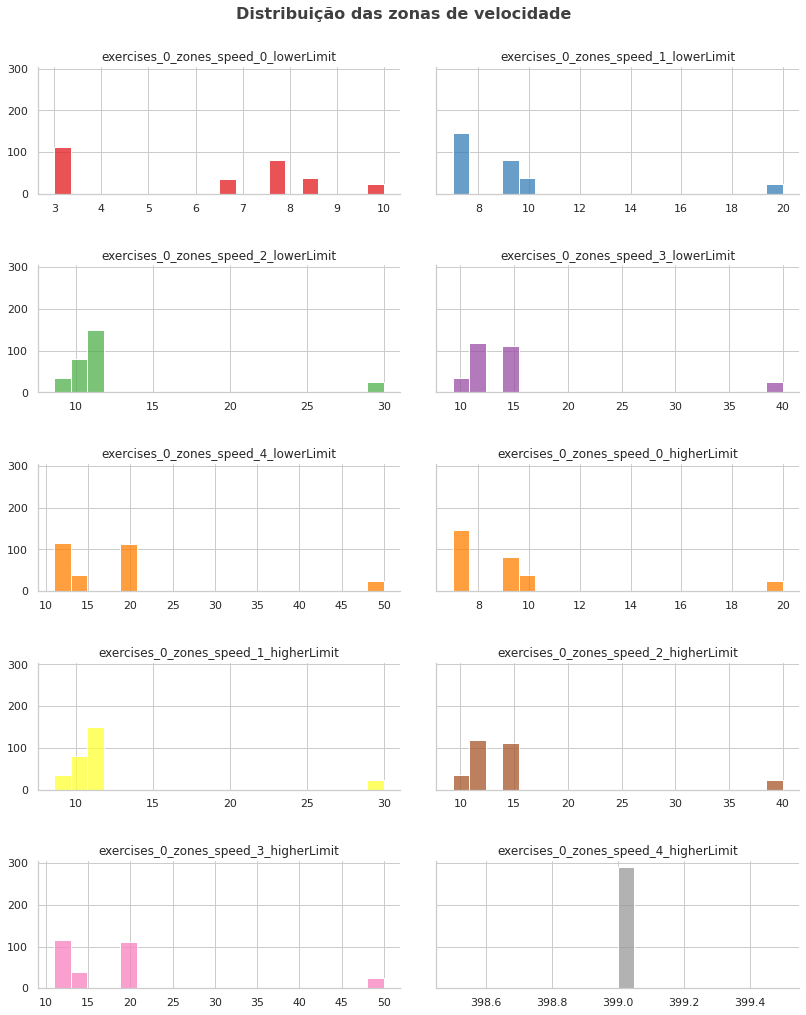

In [ ]:
# Distribuição das zonas de velocidade

targets = [f'exercises_0_zones_speed_{i}_lowerLimit' for i in range(5)] + [f'exercises_0_zones_speed_{i}_higherLimit' for i in range(5)]

fig, axes = plt.subplots(5,2, figsize=(12,15), sharey=True)
fig.suptitle('Distribuição das zonas de velocidade', fontsize=16, color='#404040', fontweight=600, y=0.96)
subplots = axes.reshape(-1)
colors = cmr.take_cmap_colors('Set1', 10, return_fmt='hex')
for i, target in enumerate(targets):
  sns.histplot(data=data, x=target, color=colors[i], bins=20, ax=subplots[i])
  subplots[i].set_title(target)
  subplots[i].set_xlabel(None)
  subplots[i].set_ylabel(None)

sns.despine()
fig.tight_layout(pad=3.0)
plt.show();

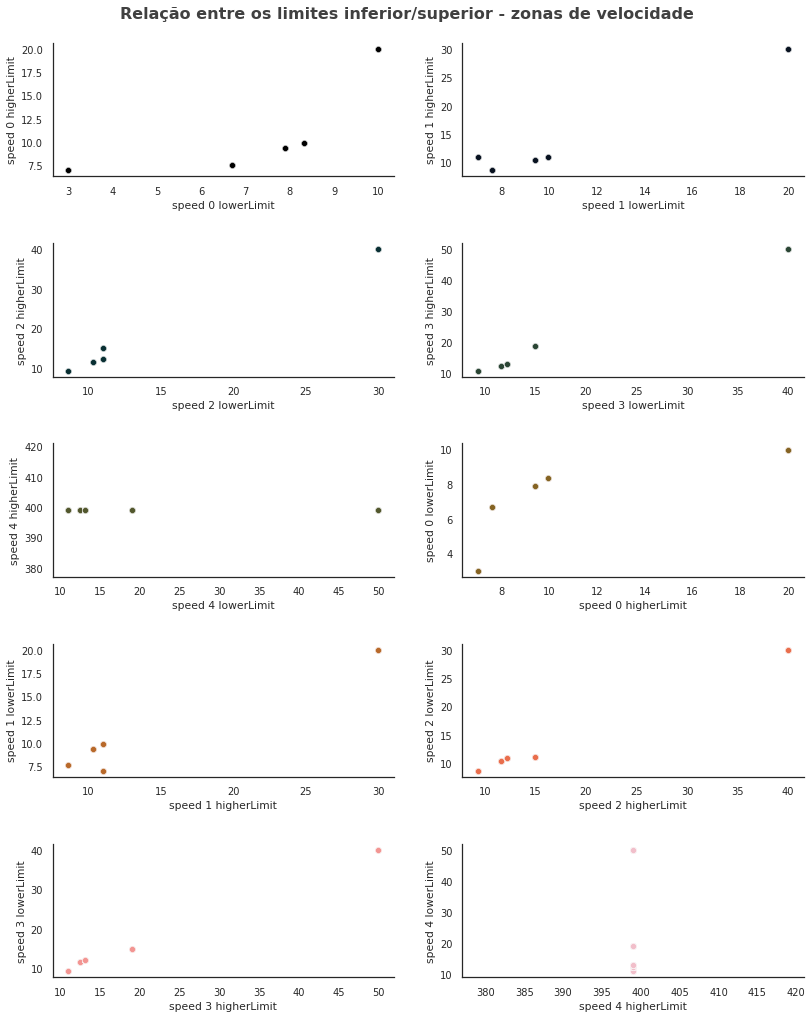

In [ ]:
# Relação entre as zonas de velocidade

targets_speed_zones = [f'exercises_0_zones_speed_{i}_lowerLimit' for i in range(5)] + [f'exercises_0_zones_speed_{i}_higherLimit' for i in range(5)]

fig, axes = plt.subplots(5,2, figsize=(12,15), sharey=False)
fig.suptitle('Relação entre os limites inferior/superior - zonas de velocidade', fontsize=16, color='#404040', fontweight=600, y=0.96)
subplots = axes.reshape(-1)
colors = cmr.take_cmap_colors('cmr.dusk', 10, return_fmt='hex')
# for i, targets in enumerate(zip(targets_heart_zones, targets_speed_zones)):
for i in range(len(targets_speed_zones)):
  sns.scatterplot(data[targets_speed_zones[i]], data[targets_speed_zones[-5+i]], color=colors[i], ax=subplots[i])
  # subplots[i].set_title(f'{targets[0]} x {targets[1]}')
  subplots[i].set_xlabel(' '.join(targets_speed_zones[i].split('_')[-3:]))
  subplots[i].set_ylabel(' '.join(targets_speed_zones[-5+i].split('_')[-3:]))

sns.despine()
fig.tight_layout(pad=3.0)
plt.show();

#### Relação entre zonas cardíacas e zonas de Velocidade

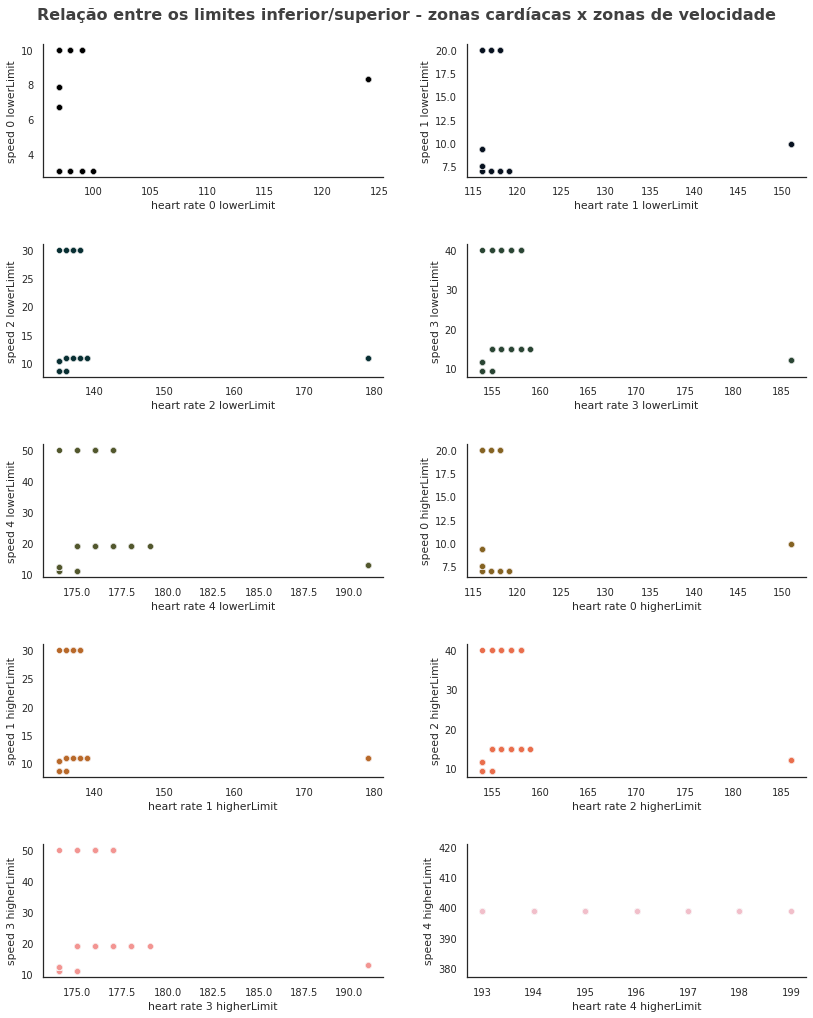

In [ ]:
fig, axes = plt.subplots(5,2, figsize=(12,15), sharey=False)
fig.suptitle('Relação entre os limites inferior/superior - zonas cardíacas x zonas de velocidade', fontsize=16, color='#404040', fontweight=600, y=0.96)
subplots = axes.reshape(-1)
colors = cmr.take_cmap_colors('cmr.dusk', 10, return_fmt='hex')
for i, targets in enumerate(zip(targets_heart_zones, targets_speed_zones)):
  sns.scatterplot(data[targets[0]], data[targets[1]], color=colors[i], ax=subplots[i])
  subplots[i].set_xlabel(' '.join(targets[0].split('_')[-4:]))
  subplots[i].set_ylabel(' '.join(targets[1].split('_')[-3:]))

sns.despine()
fig.tight_layout(pad=3.0)
plt.show();

#### Modalidades de treino mais praticadas

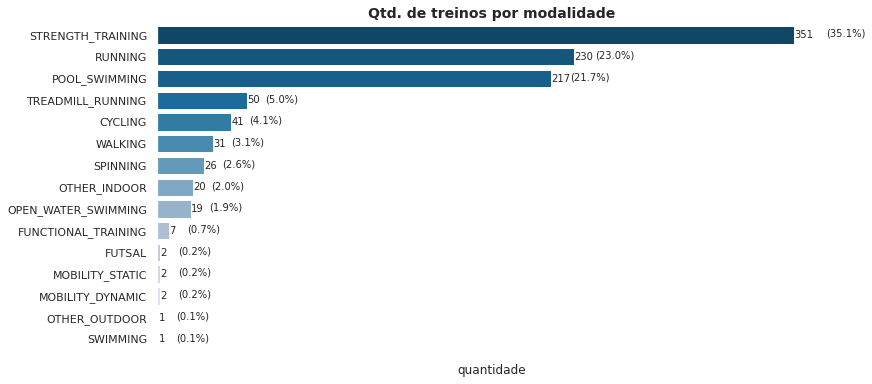

In [119]:
# Modalidades mais praticadas
grafico_quantidade(variavel='exercises_0_sport', df=data, titulo='Qtd. de treinos por modalidade', paleta='PuBu_r', tamanho=(12,6));

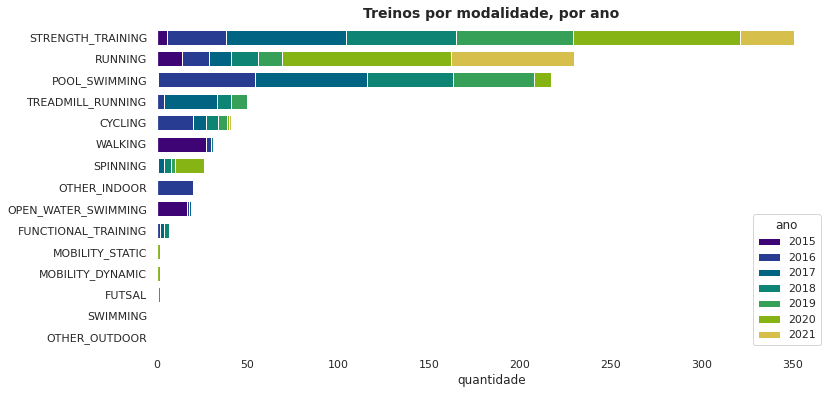

In [166]:
recorte = pd.crosstab(data['exercises_0_sport'], data['ano'])
recorte = recorte.assign(soma=recorte.sum(axis=1)).sort_values('soma')[list(range(2015,2022))]
cmap = cmr.get_sub_cmap('cmr.rainforest', 0.2, 0.8, N=7)
ax = recorte.plot(kind='barh', stacked=True, colormap=cmap, figsize=(12,6), width=0.7)

ax.set_ylabel(None)
ax.set_xlabel('quantidade')
ax.set_title('Treinos por modalidade, por ano', fontdict={'fontsize': 14, 'fontweight':'bold'});

#### Treinos por ano

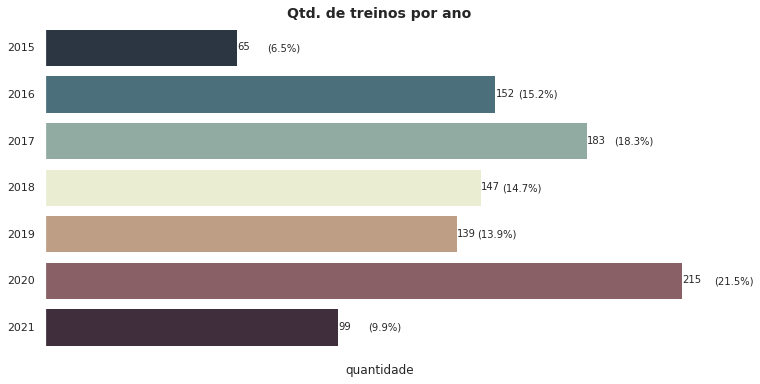

In [30]:
grafico_quantidade(variavel='ano', df=data, titulo='Qtd. de treinos por ano', paleta='cmr.copper', tamanho=(12,6), orderbyqtd=False);

#### Treinos por meses do ano

In [ ]:
month_dict = {1: 'janeiro',
              2: 'fevereiro',
              3: 'março',
              4: 'abril',
              5: 'maio',
              6: 'junho',
              7: 'julho',
              8: 'agosto',
              9: 'setembro',
              10: 'outubro',
              11: 'novembro',
              12: 'dezembro'}

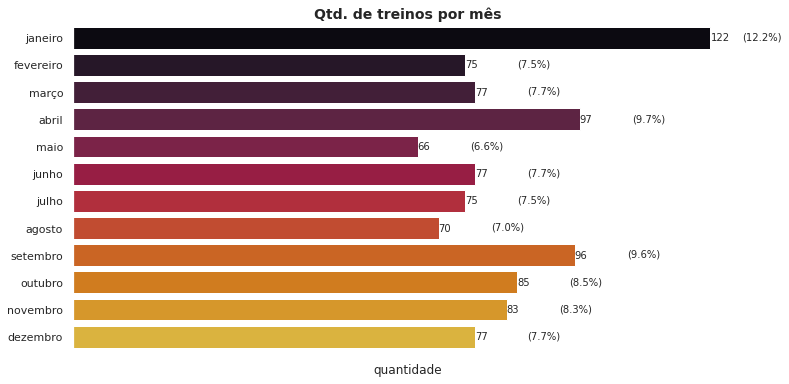

In [ ]:
grafico_quantidade(variavel='mês', df=data, titulo='Qtd. de treinos por mês', paleta='cmr.ember', tamanho=(12,6), dict_de_para=month_dict);

#### Frequência de prática das modalidades ao longo do tempo

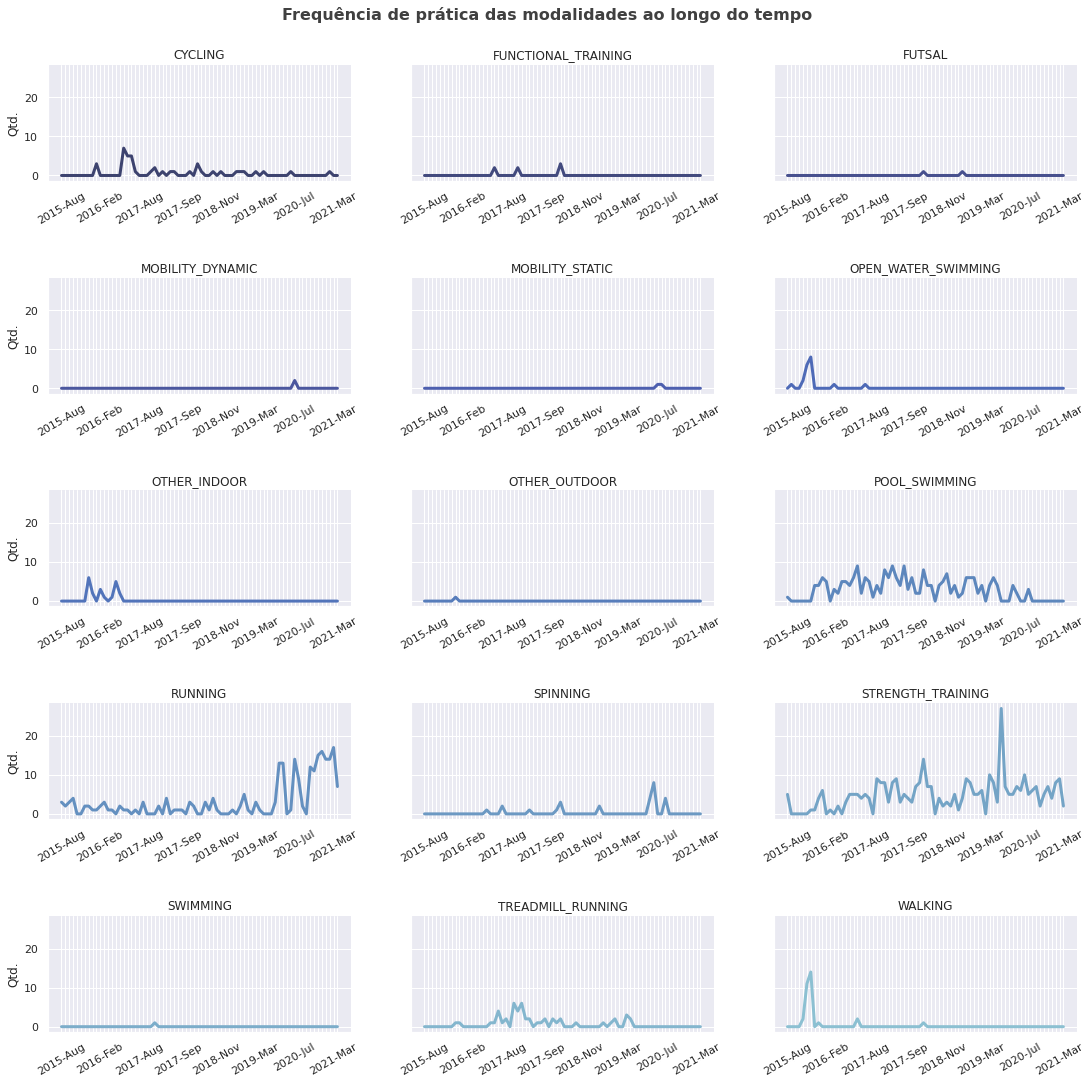

In [ ]:
# Frequência de prática das modalidades ao longo do tempo
recorte = pd.crosstab(data['exercises_0_startTime'].dt.strftime('%Y-%b'), data['exercises_0_sport']).reset_index()
# df_melted = pd.melt(recorte, id_vars=['exercises_0_startTime'], value_vars=recorte.columns[1:].to_list(), var_name='sport_category')

sub_lineplots(data=recorte, X=recorte['exercises_0_startTime'], targets=recorte.columns[1:], shape=(5,3), titulo='Frequência de prática das modalidades ao longo do tempo', label_y='Qtd.')

#### Distancias percorridas ao longo do tempo, por modalidade

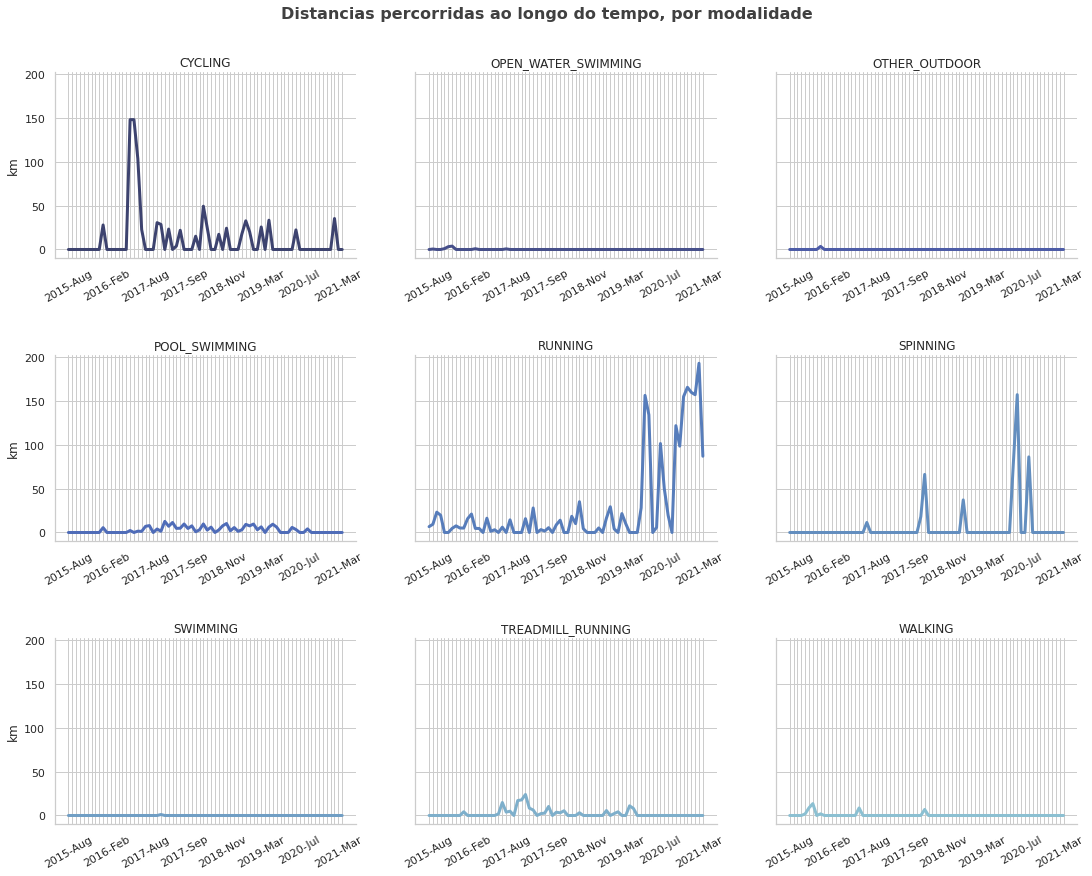

In [ ]:
# Distancias percorridas ao longo do tempo, por modalidade
recorte = pd.crosstab(data['exercises_0_startTime'].dt.strftime('%Y-%b'), data['exercises_0_sport'], values=data['exercises_0_distance']/1000, aggfunc=sum).fillna(0)
recorte = recorte.loc[:, recorte.sum()>0]
sub_lineplots(data=recorte, X=recorte.index, targets=recorte.columns, shape=(3,3), titulo='Distancias percorridas ao longo do tempo, por modalidade', label_y='km', figsize=(16,13))

#### Distribuição das distâncias percorridas por ano

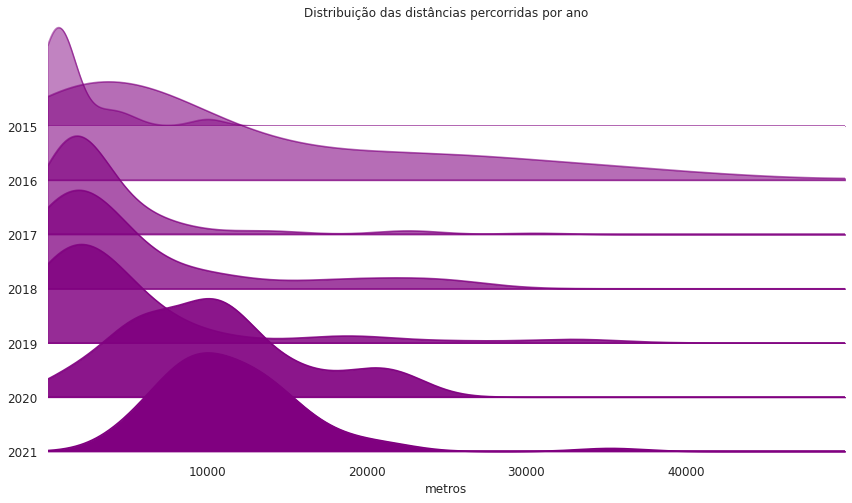

In [107]:
joyplot(data.loc[data['exercises_0_distance']>0], by='ano', 
        column='exercises_0_distance', 
        color='Purple', 
        fade=True, 
        linecolor='purple',
        title='Distribuição das distâncias percorridas por ano',
        figsize=(12,7),
        x_range=[0,50000],
        grid='y',
        ylim='own',
        )
plt.xlabel("metros")
plt.show()

#### Gasto de calorias ao longo do tempo, por modalidade

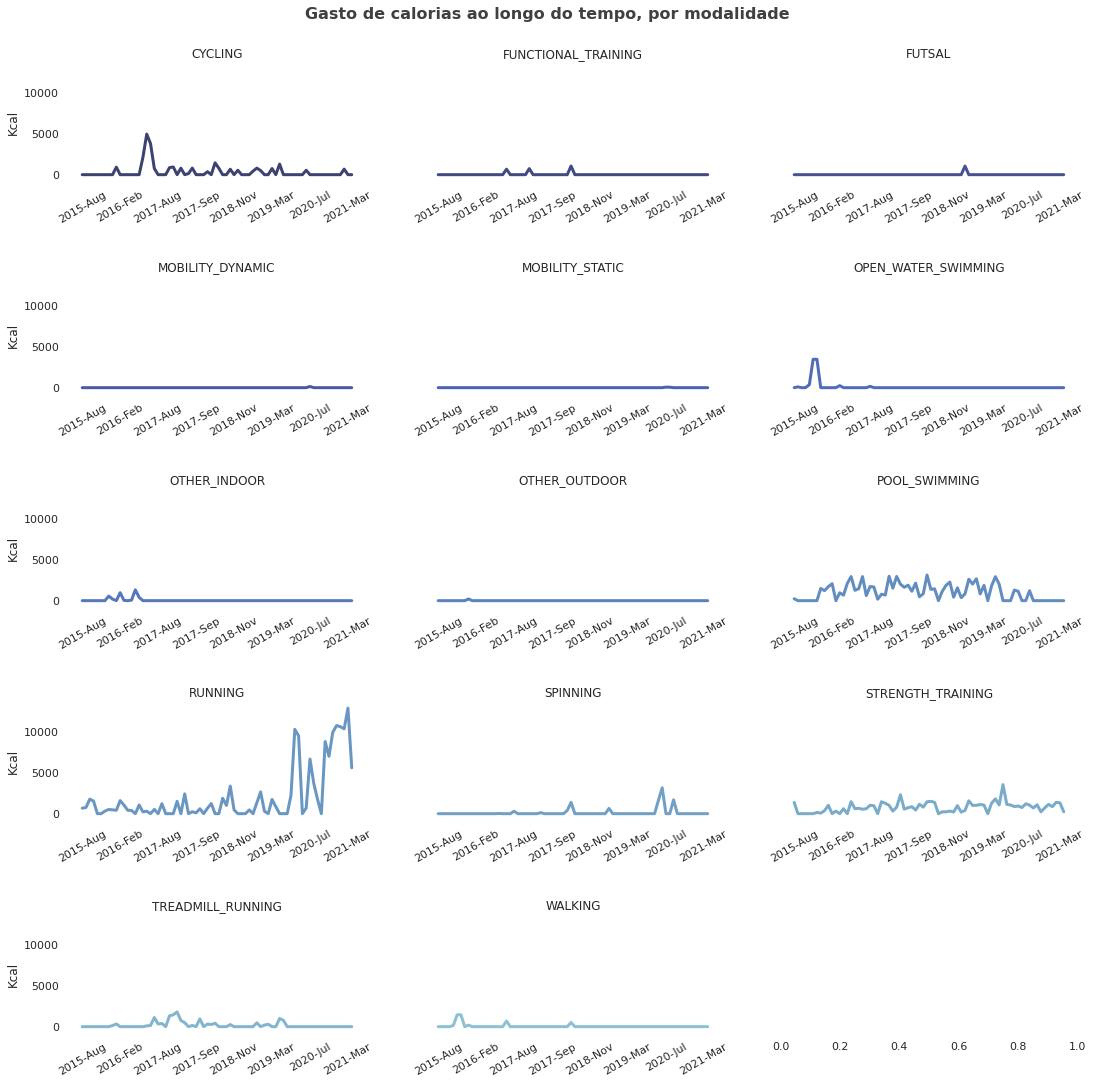

In [ ]:
# Gasto de calorias ao longo do tempo, por modalidade
recorte = pd.crosstab(data['exercises_0_startTime'].dt.strftime('%Y-%b'), data['exercises_0_sport'], values=data['exercises_0_kiloCalories'], aggfunc=sum).fillna(0)
recorte = recorte.loc[:, recorte.sum()>0]
sub_lineplots(data=recorte, X=recorte.index, targets=recorte.columns, shape=(5,3), titulo='Gasto de calorias ao longo do tempo, por modalidade', label_y='Kcal')

#### Distribuição do gasto calórico por ano

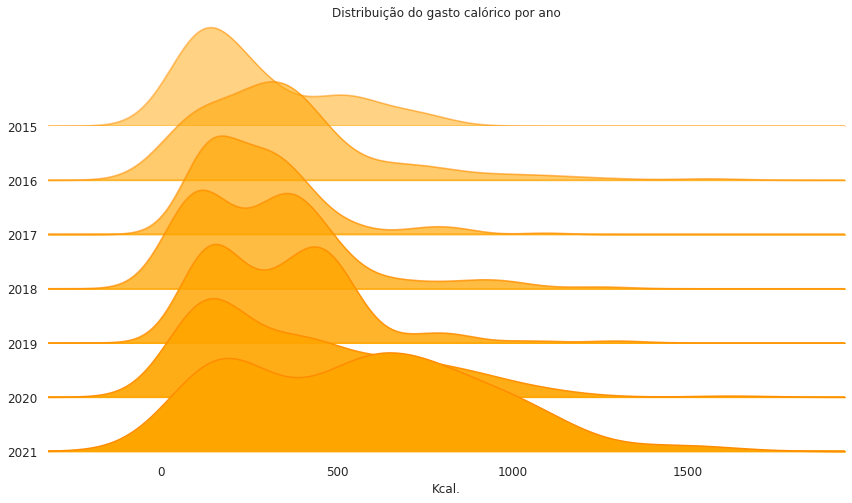

In [113]:
joyplot(data, by='ano', 
        column='exercises_0_kiloCalories', 
        color='Orange', 
        fade=True, 
        linecolor='darkorange',
        title='Distribuição do gasto calórico por ano',
        figsize=(12,7),
        grid='y',
        ylim='own',
        )
plt.xlabel("Kcal.")
plt.show()

#### Correlação entre as variáveis

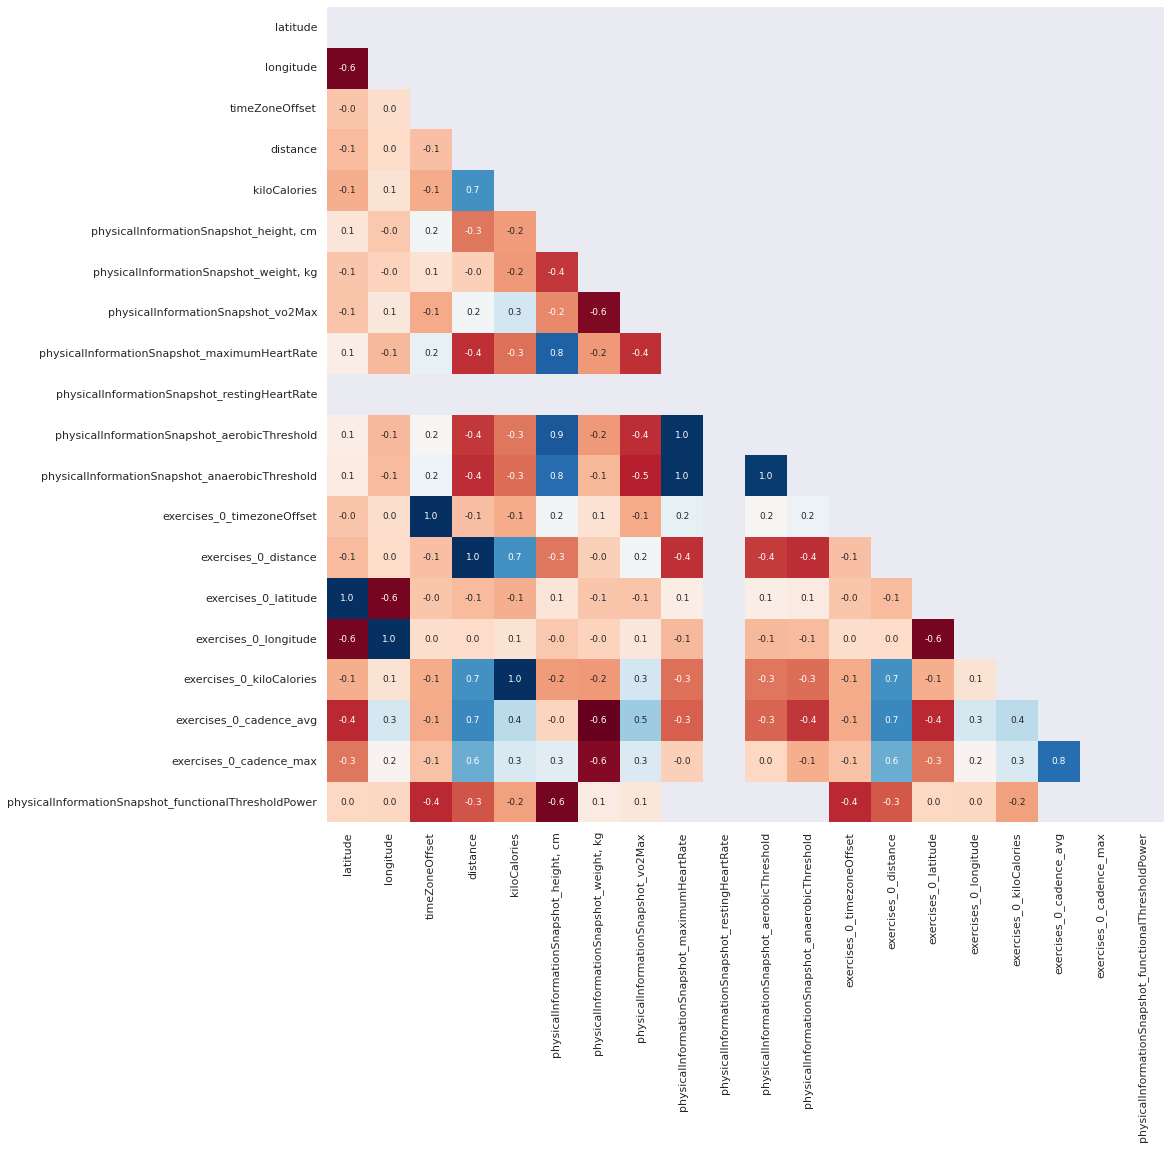

In [ ]:
# Gráfico de correlação
sns.set(rc={'figure.figsize':(15,15)})

df_corr = data.loc[:, data.columns[~data.columns.str.startswith('exercises_0_zones')]]

mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))
sns.heatmap(df_corr.corr(), annot=True, fmt='.1f', cmap='RdBu', mask=mask, cbar=False, annot_kws={'fontdict':{'fontsize':9}});

#### Onde os treinos acontecem - Geo

In [ ]:
import folium
from folium.plugins import HeatMap

In [ ]:
rush = data.groupby(['exercises_0_latitude','exercises_0_longitude'])['exercises_0_sport'].count().reset_index(name='qtd_treinos')

In [ ]:
rush['exercises_0_latitude'] = rush['exercises_0_latitude'].astype(float)
rush['exercises_0_longitude'] = rush['exercises_0_longitude'].astype(float)
rush = rush.dropna(axis=0, subset=['exercises_0_latitude','exercises_0_longitude'])

In [ ]:
loc_lat, loc_lon = rush['exercises_0_latitude'].mean(), rush['exercises_0_longitude'].mean()

In [ ]:
f = folium.Figure(width=600, height=500)
basemap = folium.Map(zoom_start=3.5, location=[loc_lat, loc_lon]).add_to(f)

In [ ]:
HeatMap(rush[['exercises_0_latitude','exercises_0_longitude']].values, radius=15, max_zoom=12).add_to(basemap)
basemap

**Verificando um dia específico da semana**

In [ ]:
data['weekday'] = data['exercises_0_startTime'].dt.day_name()

In [ ]:
def plot_day(df,day):
  f = folium.Figure(width=600, height=500)
  basemap = basemap=folium.Map(zoom_start=10, location=[loc_lat, loc_lon]).add_to(f)
  df_out=df[df['weekday']==day]
  rush = df_out.groupby(['exercises_0_latitude','exercises_0_longitude'])['weekday'].count().reset_index()    
  HeatMap(rush[['exercises_0_latitude','exercises_0_longitude']].values,radius=15).add_to(basemap)
  return basemap

In [ ]:
plot_day(data,'Saturday')